# Classification Model for Churn Analysis
- Author: Ronny Kabiru
- Program: DS-FT08 Westlands Hybrid
- Date: 07/06/2024
- TM: Maryann Mwikali


## Business Problem

For telecommunication companies to grow their revenue generating base, it is key to attract new customers and at the same time increase customer retention rate. Customer churn is one of the most important concerns for large companies. Customer churn is a metric showing when a subscriber or a regular customer cancels his subscription or stops doing business with a company. Churn could be due to various factors, including switching to a competitor for better price offers, cancelling their subscription because of poor customer service, or discontinuing all contact with a brand due to insufficient touchpoints.
Syriatel is a provider of mobile telecommunication and data services based in Damascus, Syria. The company offers services including calls, news, message, GSM and internet services. It has successfully established its reputation by focusing on customer satisfaction and social responsibility. Syriatel has established that long-term relationships with customers are more effective than trying to attract new customers. To them, working to keep a client is cheaper than working to get a new client. Churn prediction has therefore become a very important part of the company's strategy. This project aims to develop a model which accurately predicts customers who are most likely to churn, and identify the features that are important for predicting customer churn. Syriatel can thus act to prevent the customer who is likely to churn from actually churning.

## The Data

The dataset that I was given to work with contains information for 3333 accounts(columns), including:
- State
- Account Length
- Area Code
- Phone Number
- Extra Plans (VoiceMail and/or International)
- Minutes Used (Day, Evening, Night, International)
- Number of Calls (Day, Evening, Night, International)
- Number of VoiceMail Messages
- Total Amount Charged for minutes used (Day, Evening, Night, International)
- Number of calls to Customer Service

and most importantly:
- Churn: Customers who cancelled their service.

## Questions to Answer
1. What is the Baseline Churn Rate?
2. What factors contribute to churn?
3. What factors have the biggest impact on churn?
4. What can be done to identify when a customer is at risk for churn?
5. What can be done to prevent churn?

## What I will be looking for in my models
1. <b>High Recall Score:</b> I want my model to be able to predict which customers are at risk of churning. If it is tuned to be too sensitive in this area, that is fine. I would rather flag customers that aren't going to churn rather than focus on the customers that are likely to stay, and ending up with unexpected churn. I will keep this in balance by checking F1 Score.

2. <b>Good F1 Score:</b>While I am ultimately not concerned with Precision (how well the model predicts customers that will stay), a good F1 score means that the model is performing well on both Recall and Precision. Since Recall and Precision are inverses of each other, a good F1 score ensures that the model isn't skewed too far toward one or the other. (ie, a model that predicts EVERY customer will churn would have perfect Recall, but would be useless).

3. <b>High Cross Validation Score:</b> This ensures that the model isn't overly trained on the test data and that it does a good job of predicted unseen and unknown data. (ie, the test set).

4. <b>Area Under the Curve (AUC):</b> The ROC AUC Score measures the Area under the ROC curve, which means that it classifies the true positive rate against the false positive rate. The higher the score, the better performing the model is. That said, here is the scale that I will use to evaluate my models:
- <u><b>.69 or less:</u></b> Model performs only slightly better than guessing and is worthless for my analysis.
- <u><b>.70 - .79:</u></b> Model still isn't performing very well, but is at minimum acceptable levels.
- <u><b>.80 - .89:</u></b> Model is performing fairly well. My goal is to be in this range or better.
- <u><b>.90 - .99:</u></b> Model is performing very well. I would be very happy to have a final model in this range.

# Data Preparation

## Importing necessary libraries

In [249]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib.ticker as mtick

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [250]:
pd.set_option('display.max_rows', 1000) #change the amount of rows displayed
plt.style.use('fivethirtyeight')

## Reading the file

In [251]:
df = pd.read_csv(r'D:\Moringa Data Science\Moringa Projects\phase-3-individual-project\data\bigml_59c28831336c6604c800002a.csv')

df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Checking column names

In [252]:
df.columns = df.columns.str.replace(' ', '_')
df.columns

Index(['state', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls', 'churn'],
      dtype='object')

# EDA

In [253]:
df.describe()

,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account_length          3333 non-null   int64  
 2   area_code               3333 non-null   int64  
 3   phone_number            3333 non-null   object 
 4   international_plan      3333 non-null   object 
 5   voice_mail_plan         3333 non-null   object 
 6   number_vmail_messages   3333 non-null   int64  
 7   total_day_minutes       3333 non-null   float64
 8   total_day_calls         3333 non-null   int64  
 9   total_day_charge        3333 non-null   float64
 10  total_eve_minutes       3333 non-null   float64
 11  total_eve_calls         3333 non-null   int64  
 12  total_eve_charge        3333 non-null   float64
 13  total_night_minutes     3333 non-null   float64
 14  total_night_calls       3333 non-null   

In [255]:
df.isna()

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3329,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3330,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3331,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [256]:
df.isna().sum()

state                     0
account_length            0
area_code                 0
phone_number              0
international_plan        0
voice_mail_plan           0
number_vmail_messages     0
total_day_minutes         0
total_day_calls           0
total_day_charge          0
total_eve_minutes         0
total_eve_calls           0
total_eve_charge          0
total_night_minutes       0
total_night_calls         0
total_night_charge        0
total_intl_minutes        0
total_intl_calls          0
total_intl_charge         0
customer_service_calls    0
churn                     0
dtype: int64

In [257]:
df.phone_number.duplicated().sum()

0

In [258]:
df.churn.value_counts()

churn
False    2850
True      483
Name: count, dtype: int64

There is a Churn Class Imbalance. False has 2850 values and True has 483 values.

In [259]:
# Calculating Churn rate
churn_rate = (483/3333) * 100
print(f'The Churn Rate is', churn_rate,'%')

The Churn Rate is 14.491449144914492 %


In [260]:
# There are 3333 records.
# No missing values, and no duplicates.
# The number of customers who churned was 483.
# Therefore the base churn rate is (483 / 3333) * 100 = 14.49%

## Data Cleaning and Preprocessing

In [261]:
test_df = df.copy()
test_df.head(2)        #Checking the copy is accurate

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False


In [262]:
test_df["churn"] = test_df["churn"].astype(int)
test_df.churn.value_counts()

churn
0    2850
1     483
Name: count, dtype: int64

In the above cell, we assign 0 to represent False and 1 to represent True.

In [263]:
# Dropping unnecessary columns
test_df = test_df.drop(columns=['state','phone_number', 'area_code'], axis=1)
test_df.head()

#Those columns are serving as identifiers and won't be necessary for this project

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,128,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,107,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,137,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,84,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,75,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [264]:
# Adding necessary columns
total_charge = test_df.apply(lambda x: x['total_day_charge'] + x['total_eve_charge'] +x['total_night_charge']
                             +x['total_intl_charge'], axis=1)
test_df['total_charge']= total_charge

#Total Charge represents the summation of charges the customer is billed

### Removing object dtypes

In [265]:
# Select continuous features
cont_features = [col for col in test_df.columns if test_df[col].dtype in [np.float64, np.int64]]

# Ensure 'churn' column is included
if 'churn' not in cont_features:
    cont_features.append('churn')

feature_df = test_df.loc[:, cont_features]
feature_df.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,total_charge,churn
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,75.56,0
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,59.24,0
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,62.29,0
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,66.80,0
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,52.09,0


### One Hot Encoding

In [266]:
need_encode = test_df[['international_plan', 'voice_mail_plan', 'customer_service_calls']]
ohe = OneHotEncoder()
ohe.fit(need_encode)

ohe_1 = ohe.transform(need_encode).toarray()

ohe_df = pd.DataFrame(ohe_1, columns=ohe.get_feature_names_out(need_encode.columns))
ohe_df.head(2)

,international_plan_no,international_plan_yes,voice_mail_plan_no,voice_mail_plan_yes,customer_service_calls_0,customer_service_calls_1,customer_service_calls_2,customer_service_calls_3,customer_service_calls_4,customer_service_calls_5,customer_service_calls_6,customer_service_calls_7,customer_service_calls_8,customer_service_calls_9
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [267]:
# Combining everything together
cleaned_df = pd.concat([pd.DataFrame(feature_df), ohe_df], axis=1)
cleaned_df.head(2)

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,customer_service_calls_0,customer_service_calls_1,customer_service_calls_2,customer_service_calls_3,customer_service_calls_4,customer_service_calls_5,customer_service_calls_6,customer_service_calls_7,customer_service_calls_8,customer_service_calls_9
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [268]:
#Dropping a few of the redundant values.
cleaned_df_2 = cleaned_df.copy()
cleaned_df_2 = cleaned_df_2.drop(['international_plan_no', 'voice_mail_plan_no'], axis=1)
cleaned_df_2.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,customer_service_calls_0,customer_service_calls_1,customer_service_calls_2,customer_service_calls_3,customer_service_calls_4,customer_service_calls_5,customer_service_calls_6,customer_service_calls_7,customer_service_calls_8,customer_service_calls_9
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Creating Variable: Customer Service Calls High
- Customer Service Calls High = 4 or more Customer Service Calls.
- This is to determine if a high number of Customer Service Calls affects Churn.
- I'm introducing only the High Customer Service Calls variable as any account that isn't in the "High" range is in the "Low" range.

In [269]:
cs_calls_high= cleaned_df_2.apply(lambda x: x['customer_service_calls_4'] + x['customer_service_calls_5']
                                           + x['customer_service_calls_6'] + x['customer_service_calls_7']
                                            + x['customer_service_calls_8']+ x['customer_service_calls_9'], axis=1)

cleaned_df_2['cs_calls_high'] = cs_calls_high

In [270]:
cleaned_df_2 = cleaned_df_2.drop(['customer_service_calls_0', 'customer_service_calls_1','customer_service_calls_2','customer_service_calls_3',
                                    'customer_service_calls_4','customer_service_calls_5','customer_service_calls_6',
                                        'customer_service_calls_7','customer_service_calls_8','customer_service_calls_9']
                                            , axis=1)
cleaned_df_2.head(2)

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,total_charge,churn,international_plan_yes,voice_mail_plan_yes,cs_calls_high
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,75.56,0,0.0,1.0,0.0
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,59.24,0,0.0,1.0,0.0


In [271]:
total_charge = cleaned_df_2.apply(lambda x: x['total_day_charge'] + x['total_eve_charge'] +x['total_night_charge']
                             +x['total_intl_charge'], axis=1)
cleaned_df_2['total_charge']= total_charge

# Modeling

In [272]:
# Creating a df that we'll use for modeling
model_df = cleaned_df_2.copy()
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account_length          3333 non-null   int64  
 1   number_vmail_messages   3333 non-null   int64  
 2   total_day_minutes       3333 non-null   float64
 3   total_day_calls         3333 non-null   int64  
 4   total_day_charge        3333 non-null   float64
 5   total_eve_minutes       3333 non-null   float64
 6   total_eve_calls         3333 non-null   int64  
 7   total_eve_charge        3333 non-null   float64
 8   total_night_minutes     3333 non-null   float64
 9   total_night_calls       3333 non-null   int64  
 10  total_night_charge      3333 non-null   float64
 11  total_intl_minutes      3333 non-null   float64
 12  total_intl_calls        3333 non-null   int64  
 13  total_intl_charge       3333 non-null   float64
 14  customer_service_calls  3333 non-null   

In [273]:
# Removing noise in the dataframe
model_df=model_df.drop(['customer_service_calls','total_day_charge', 'total_eve_charge', 'total_night_charge', 'total_intl_charge'], axis=1)
model_df.head(2)


,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,total_charge,churn,international_plan_yes,voice_mail_plan_yes,cs_calls_high
0,128,25,265.1,110,197.4,99,244.7,91,10.0,3,75.56,0,0.0,1.0,0.0
1,107,26,161.6,123,195.5,103,254.4,103,13.7,3,59.24,0,0.0,1.0,0.0


### Correcting imbalance in the Churn class

In [274]:
balanced_df = model_df.copy()

X = balanced_df.drop(['churn'], axis=1)
y = balanced_df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=23)

smote = SMOTE(random_state=23)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) 

### Function to get necessary metrics
- It will calculate and display the following metrics:
    1. Recall
    2. F1 Score
    3. ROC AUC Score

In [275]:
def metrics(clf, y_pred):
    
    clf_recall = recall_score(y_test, y_pred) * 100
    print('Recall is :{0}'.format(clf_recall))
    clf_f1 = f1_score(y_test, y_pred) * 100
    print('F1 Score is :{0}'.format(clf_f1))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    clf_roc_auc = auc(false_positive_rate, true_positive_rate)
    print('ROC AUC is :{0}'.format(round(clf_roc_auc, 2)))
    

## Base Model

### Decision Tree

In [276]:
dt1 = DecisionTreeClassifier(random_state=42, class_weight="balanced")
dt1.fit(X_train_resampled, y_train_resampled)
dt1_y_pred = dt1.predict(X_test)

In [277]:
metrics(dt1, dt1_y_pred)

Recall is :84.29752066115702
F1 Score is :79.37743190661479
ROC AUC is :0.9


In [278]:
dt1_cv_score = np.mean(cross_val_score(dt1, X_train_resampled, y_train_resampled, cv=3))
dt1_cv_score

0.9515682699257507

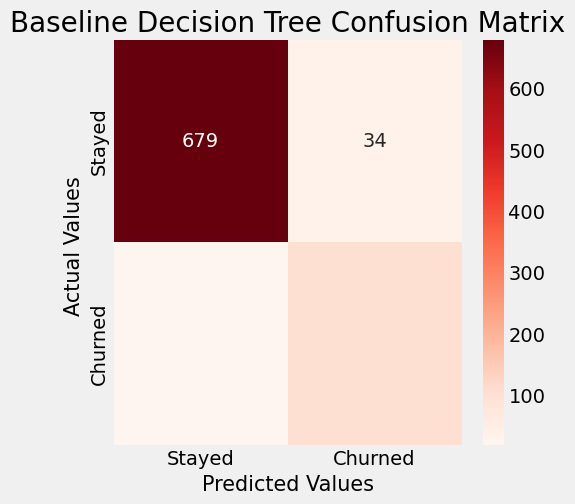

In [279]:
dt1_matrix = confusion_matrix(y_test, dt1_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(dt1_matrix, annot=True, cmap='Reds', fmt='d', ax=ax, cbar=True)

ax.set_title('Baseline Decision Tree Confusion Matrix', fontsize = 20)
ax.set_xlabel('Predicted Values',fontsize = 15)
ax.set_ylabel('Actual Values ', fontsize=15)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Stayed','Churned'])
ax.yaxis.set_ticklabels(['Stayed','Churned'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Analysis:
- Recall is decent, F1 score is okay, and ROC AUC score is very good. The first model is performing well.
- I will use GridSearch to optimize my Decision Tree.

### Refining Decision Tree through GridSearchCV

In [280]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [281]:
# Instantiate GridSearchCV
dt2 = DecisionTreeClassifier(random_state=23)

dt_grid_search = GridSearchCV(dt2, dt_param_grid, cv=3, scoring = 'recall')

# Fit to the data
dt_grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=23),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             scoring='recall')

In [282]:
dt_grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

### Decision Tree 2 (Using Grid Search Parameters)

In [283]:
dt2 = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=2,
                             min_samples_leaf=1, class_weight='balanced', random_state=23)
dt2.fit(X_train_resampled, y_train_resampled)
dt2_y_pred = dt2.predict(X_test)

In [284]:
metrics(dt2, dt2_y_pred)

Recall is :85.12396694214877
F1 Score is :82.07171314741036
ROC AUC is :0.91


In [285]:
dt2_cv_score = np.mean(cross_val_score(dt2, X_train_resampled, y_train_resampled, cv=3))
dt2_cv_score

0.9588203889874499

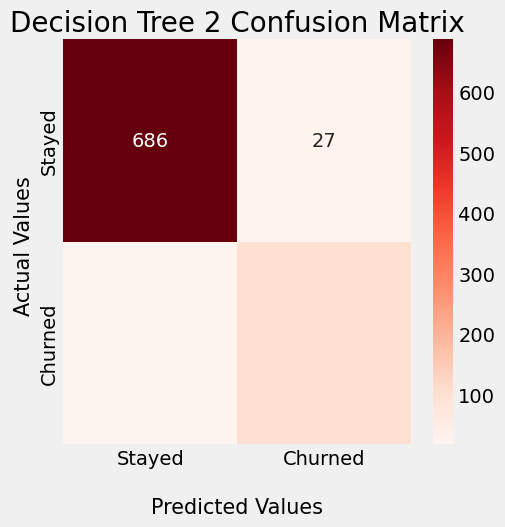

In [286]:
dt2_matrix = confusion_matrix(y_test, dt2_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(dt2_matrix, annot=True, cmap='Reds', fmt='d', ax=ax, cbar=True)

ax.set_title('Decision Tree 2 Confusion Matrix', fontsize = 20)
ax.set_xlabel('\nPredicted Values',fontsize = 15)
ax.set_ylabel('Actual Values ', fontsize=15)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Stayed','Churned'])
ax.yaxis.set_ticklabels(['Stayed','Churned'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Analysis:
- Decision Tree 2 performs slightly better than Decision Tree 1 on all metrics.

 -----

## Model 2: Random Forest